In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

import tensorflow as tf
from tensorflow.keras import layers, regularizers, optimizers

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2023-08-08 04:52:59.042043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 04:52:59.091983: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 04:52:59.092774: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 04:52:59.879588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)

zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')
zarr_ds = zarr_ds.sel(time=slice('2020-01-01', '2022-12-31'))

In [3]:
import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

processed_data = preprocess_data(zarr_ds).compute()

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

In [4]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [5]:

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

# def build_convLSTM_model(input_shape=(5, 149, 181, 1), output_shape=(149, 181, 1)):
#     """
#     Build a ConvLSTM model.
    
#     Args:
#     - input_shape (tuple): Shape of the input data. Default is (5, 149, 181, 1).
#     - output_shape (tuple): Shape of the output data. Default is (149, 181, 1).
    
#     Returns:
#     - model (keras Model): ConvLSTM model.
#     """
    
#     model = Sequential()
    
#     # First ConvLSTM layer
#     model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True,
#                          input_shape=input_shape, activation='relu'))
#     model.add(BatchNormalization())
    
#     # Second ConvLSTM layer
#     model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False,
#                          activation='relu'))
#     model.add(BatchNormalization())

#     # A Conv2D layer to produce the final output
#     model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))
    
#     model.compile(optimizer='adam', loss='mse')  # For regression tasks, 'mse' is a common choice. Adjust as needed.
    
#     return model

# # Construct the model
# model = build_convLSTM_model()
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 5, 149, 181, 64)   150016    
                                                                 
 batch_normalization (Batch  (None, 5, 149, 181, 64)   256       
 Normalization)                                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 149, 181, 64)      295168    
                                                                 
 batch_normalization_1 (Bat  (None, 149, 181, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d (Conv2D)             (None, 149, 181, 1)       577       
                                                                 
Total params: 446273 (1.70 MB)
Trainable params: 446017 

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

def create_simple_model(input_shape=(5, 149, 181, 1)):
    model = Sequential()

    # ConvLSTM layer
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=False))
    model.add(BatchNormalization())
    
    # Conv2D layer for output
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

model = create_simple_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 149, 181, 32)      38144     
                                                                 
 batch_normalization (Batch  (None, 149, 181, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 149, 181, 1)       289       
                                                                 
Total params: 38561 (150.63 KB)
Trainable params: 38497 (150.38 KB)
Non-trainable params: 64 (256.00 Byte)
_________________________________________________________________


In [6]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/20
21/21 [==============================] - 151s 7s/step - loss: 0.7728 - mae: 0.4364 - val_loss: 1.2466 - val_mae: 0.6278
Epoch 2/20
21/21 [==============================] - 149s 7s/step - loss: 0.1059 - mae: 0.1837 - val_loss: 1.2699 - val_mae: 0.6365
Epoch 3/20
21/21 [==============================] - 149s 7s/step - loss: 0.0700 - mae: 0.1549 - val_loss: 1.2609 - val_mae: 0.6372
Epoch 4/20
21/21 [==============================] - 149s 7s/step - loss: 0.0587 - mae: 0.1449 - val_loss: 1.2156 - val_mae: 0.6184
Epoch 5/20
21/21 [==============================] - 149s 7s/step - loss: 0.0503 - mae: 0.1363 - val_loss: 1.1791 - val_mae: 0.6131
Epoch 6/20
21/21 [==============================] - 148s 7s/step - loss: 0.0476 - mae: 0.1336 - val_loss: 1.1465 - val_mae: 0.6050
Epoch 7/20
21/21 [==============================] - 150s 7s/step - loss: 0.0477 - mae: 0.1372 - val_loss: 1.0743 - val_mae: 0.5827
Epoch 8/20
21/21 [==============================] - 149s 7s/step - loss: 0.0461 - m

In [7]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

In [8]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

(5, 149, 181)
(149, 181)
1/1 [==============================] - 0s 66ms/step
(149, 181, 1)


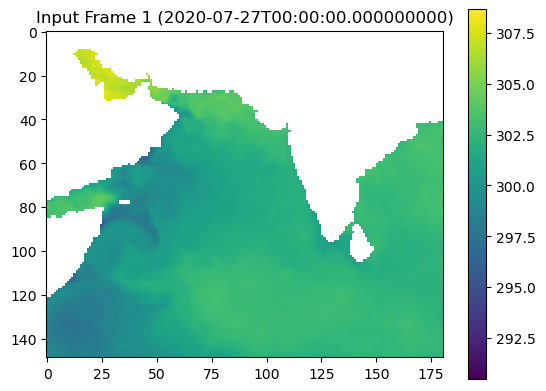

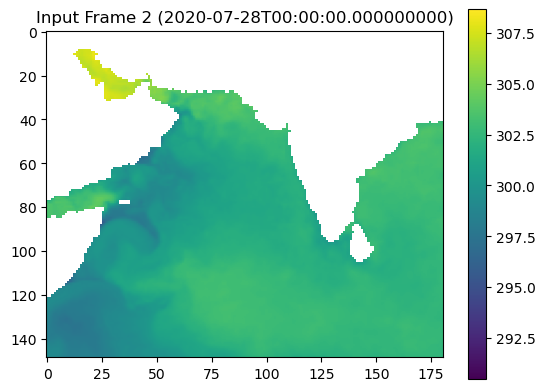

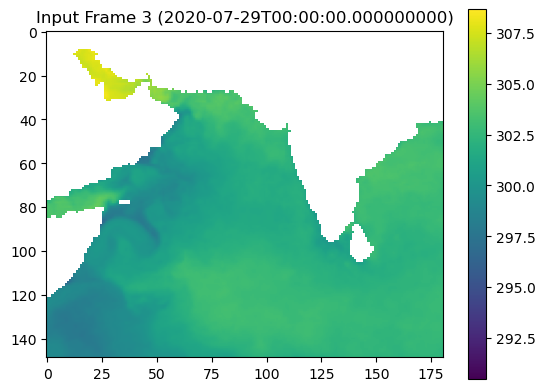

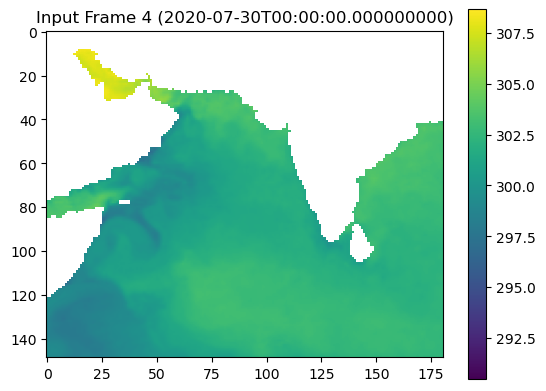

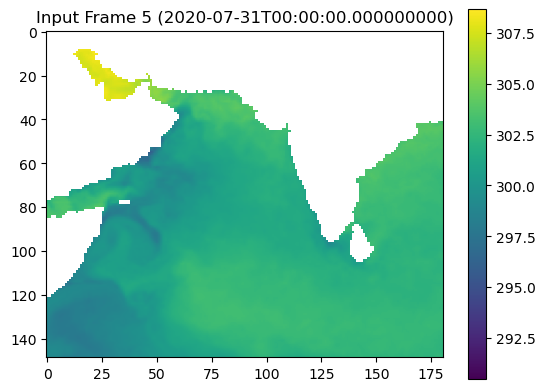

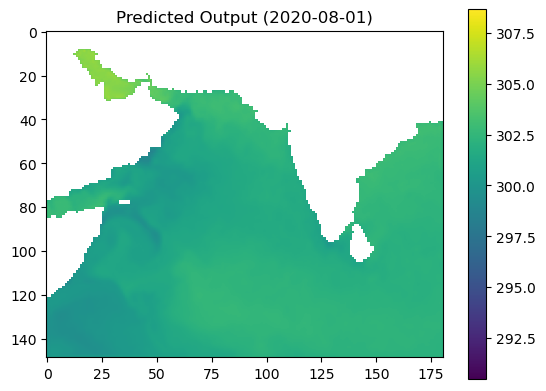

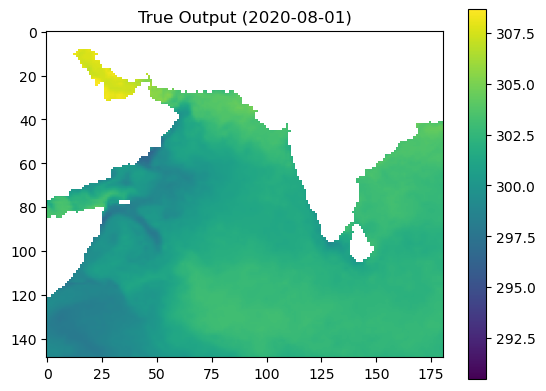

MAE between Predicted Output and True Output: 0.5621228814125061
MAE between Last Input Frame and True Output: 0.143082395195961


In [10]:
date_to_predict = '2020-08-01'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

predicted_mae = compute_mae(true_output, predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mae = compute_mae(true_output_2d, last_input_frame_2d)
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")